In [11]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio.v2 as imageio
import cv2
import os
#from attrdict import AttrDict
from collections.abc import Mapping
from scipy import signal

In [12]:
def load_data(d_name):
    """ Load images and matches.
    
    Args:
        d_name: Should be 'house' or 'library'
        
    Returns:
        img0, img1: Images
        x0, x1: 3xN matrix of matching points
        P0, P1: 3X4 camera matrix
    """
    img0 = imageio.imread(f'{d_name}1.jpg')
    img1 = imageio.imread(f'{d_name}2.jpg')
    x0 = np.genfromtxt(f'{d_name}_matches_x1.csv', delimiter=',', dtype=np.float64)
    x1 = np.genfromtxt(f'{d_name}_matches_x2.csv', delimiter=',', dtype=np.float64)
    P0 = np.loadtxt(f'{d_name}1_camera.txt')
    P1 = np.loadtxt(f'{d_name}2_camera.txt')
    return img0, img1, x0, x1, P0, P1

def plot_multiple(images, titles=None, colormap='gray', 
                  max_columns=np.inf, imwidth=4, imheight=4, share_axes=False):
    """Plot multiple images as subplots on a grid."""
    if titles is None:
        titles = [''] *len(images)
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(n_cols * imwidth, n_rows * imheight),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    fig.tight_layout()

def draw_keypoints(img, x):
    img = img.copy()
    for p, color in zip(x.T, colors):
        cv2.circle(img, (int(p[0]), int(p[1])), thickness=2, radius=1, color=color)
    return img
    
def draw_point_matches(img0, img1, x0, x1, color_mask=None):
    result = np.concatenate([img0, img1], axis=1)
    img0_width = img0.shape[1]
    
    if color_mask is None:
        color_mask = np.ones(x0.shape[1], dtype=bool)
        
    for p0, p1, c_flag in zip(x0.T, x1.T, color_mask):
        p0x, p0y = int(p0[0]), int(p0[1])
        p1x, p1y = int(img0_width + p1[0]), int(p1[1])
        color = (0, 255, 0) if c_flag else (255, 0, 0)
        cv2.line(result, (p0x, p0y), (p1x, p1y),
                 color=color, thickness=1, lineType=cv2.LINE_AA)
    return result

def random_colors(n_colors):
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, n_colors)
    colors = plt.cm.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return colors*255

colors = random_colors(1000)

def draw_line(img, l):
    if abs(l[0]) < abs(l[1]):
        # More horizontal
        slope = -l[0] / l[1]
        intercept = -l[2] / l[1]
        xs = np.array([0, img.shape[1]])
        ys = intercept + slope * xs
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=(0, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    else:
        # More vertical
        slope = -l[1] / l[0]
        intercept = -l[2] / l[0]
        ys = np.array([0, img.shape[0]])
        xs = intercept + slope * ys
        cv2.line(img, (int(xs[0]), int(ys[0])), (int(xs[1]), int(ys[1])),
                 color=(0, 255, 255), thickness=1, lineType=cv2.LINE_AA)

def draw_points_and_epipolar_lines(img, points, lines):
    """
    Args:
        img: First or second image
        x: 3xN matrix of points (on the same image)
        l: 3xN matrix of lines (on the same image)
    """
    points = points[:2] / points[2]  # Normalize
    img = img.copy()
    
    for l in lines.T:
        draw_line(img, l)

    for (x,y), color in zip(points.T, colors):
        cv2.circle(img, (int(x), int(y)), thickness=2, radius=1, color=color)

    return img
    

## Fundamental Matrix Estimation using the Eight-Point Algorithm

In [13]:
def get_fundamental_matrix(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0.T @ F @ x1 = 0
        e0: The epipole in image 0 such that F.T  @ e0 = 0
        e1: The epipole in image 1 such that F @ e1 = 0 
    """

    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    n_pts = x0.shape[1]
    A = np.column_stack(
        (x0[0]*x1[0], x0[0]*x1[1], x0[0], x1[0]*x0[1],
         x0[1]*x1[1], x0[1], x1[0], x1[1], np.ones(n_pts)))
    
    # Applying SVD (Singular Value Decomposition)
    U, S, Vt = np.linalg.svd(A)
    F = Vt[-1].reshape(3, 3)
                       
    # Enforce rank(F) = 2
    U, S, Vt = np.linalg.svd(F)
    S[-1] = 0
    F = U @ np.diag(S) @ Vt 
    
    # Epipoles
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    
    return F, e0, e1

In order to get a quantitative estimate for the accuracy of the results, a fucntion `get_residual_distance` is defined that computed the distance between points in the one image and their corresponding epipolar lines.

In [14]:
def get_residual_distance(F, x0, x1):
    # Epipolar lines
    l0 = F @ x1
    l1 = F.T @ x0
    
    # Normalization
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    l0 = l0 / np.hypot(l0[0], l0[1])
    l1 = l1 / np.hypot(l1[0], l1[1])
    
    # Distance 
    d0 = np.abs(np.sum(l0 * x0, axis=0))
    d1 = np.abs(np.sum(l1 * x1, axis=0))
    
    return d0, d1

In [15]:
def get_residual_error(F, x0, x1):
    d0, d1 = get_residual_distance(F, x0, x1)
    return 0.5 * (np.mean(d0) + np.mean(d1))

The estimated fundamental matrix F is 
[[-1.72568743e-06 -1.93201481e-05  2.76519986e-03]
 [ 4.46652793e-06 -2.89196857e-07 -3.07503229e-02]
 [ 2.49479344e-03  3.43231535e-02 -9.98930662e-01]]
Epipole 0: [1.77464463e+03 1.27098386e+02 1.00000000e+00], epipole 1: [ 6.85424143e+03 -4.69099843e+02  1.00000000e+00]
Fitting error: 0.5 px


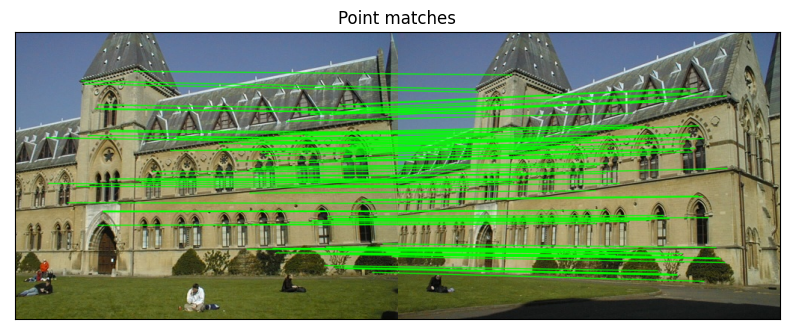

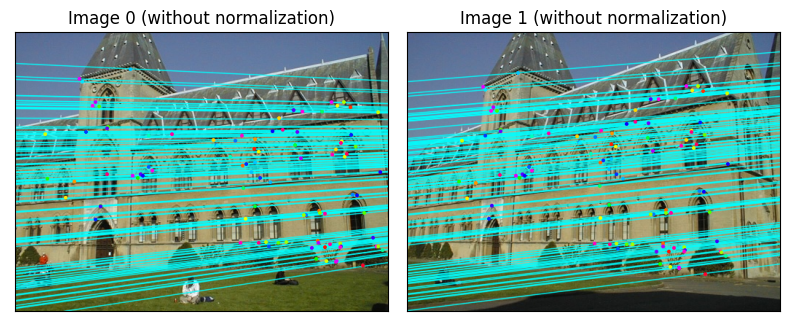

In [17]:
img0, img1, x0, x1, _, _ = load_data('library')
n_matches = 100
x0 = x0[:,:n_matches]
x1 = x1[:,:n_matches]    

F, e0, e1 = get_fundamental_matrix(x0, x1)
residual_error = get_residual_error(F, x0, x1)

print(f'The estimated fundamental matrix F is \n{F}')

plot_multiple([draw_point_matches(img0, img1, x0, x1)], 
              ['Point matches'], imwidth=8)
img0_result = draw_points_and_epipolar_lines(img0, x0, F @ x1)
img1_result = draw_points_and_epipolar_lines(img1, x1, F.T @ x0)
plot_multiple([img0_result, img1_result], 
              ['Image 0 (without normalization)', 'Image 1 (without normalization)'])

print(f'Epipole 0: {e0}, epipole 1: {e1}')
print(f'Fitting error: {residual_error:.1f} px')

### Normalization
The points nned to be normalized so that the estimation problem is well conditioned. A function `normalize_points` is defined that normalizes the given list of 2D points(in homogenuous coordinates) by first shifting their origin to the centroid and then scaling them such that their mean distance from the origin is $\sqrt{2}$.

In [18]:
def normalize_points(x):
    """
    Args:
        x: 3xN arrays of N homogenous points in 2D
        
    Return:
        x_trans: 3xN matrix of transformed points
        T: the 3x3 transformation matrix, points_trans = T * points
    """
    # Shift origin to centroid
    x = x / x[2]
    center = np.mean(x, axis=1)
    T_center = np.array([[1, 0, -center[0]],
                         [0, 1, -center[1]],
                         [0, 0, 1]])
    x_trans = T_center @ x

    # Normalize the distances
    scale = np.sqrt(2) / np.mean(np.linalg.norm(x_trans[:2], axis=0))
    T_scale = np.array([[scale, 0, 0],
                        [0, scale, 0],
                        [0, 0, 1]])
    T = T_scale @ T_center
    x_trans = T @ x
    
    return x_trans, T

Now an adapted function `get_fundamental_matrix_with_normalization` is defined which first normalizes the input points and then computes the fundamental matrix based on the normalized points. Then it undoes the transformation by applying $\mathrm{F = T_0^⊤FT_1}$ before computing the epipoles.

In [19]:
def get_fundamental_matrix_with_normalization(x0, x1):
    """
    Args:
        x0, x1: 3xN arrays of N homogenous points in 2D
        
    Returns:
        F: The 3x3 fundamental martix such that x0'*F*x1 = 0
        e0: The epipole in image 0 such that F'*e0 = 0
        e1: The epipole in image 1 such that F*e1 = 0 
    """
    x0 = x0 / x0[2]
    x1 = x1 / x1[2]
    
    x0_norm, T0 = normalize_points(x0)
    x1_norm, T1 = normalize_points(x1)
    F_norm, _, _ = get_fundamental_matrix(x0_norm, x1_norm)

    # Undo the transformation
    F = T0.T @ F_norm @ T1

    # Compute epipoles
    U, _, Vt = np.linalg.svd(F)
    e0 = U[:, -1] / U[-1, -1]
    e1 = Vt[-1, :] / Vt[-1, -1]
    
    return F, e0, e1

The estimated fundamental matrix F is 
[[-3.11400498e-07 -6.78866053e-06  1.30803314e-03]
 [ 3.14216536e-06  5.64170931e-08 -8.92017402e-03]
 [-1.32164770e-04  9.78603019e-03 -2.36676127e-01]]
Epipole 0: [1.44306399e+03 1.85074797e+02 1.00000000e+00], epipole 1: [2.83773970e+03 6.25100608e+01 1.00000000e+00]
Fitting error: 0.2 px


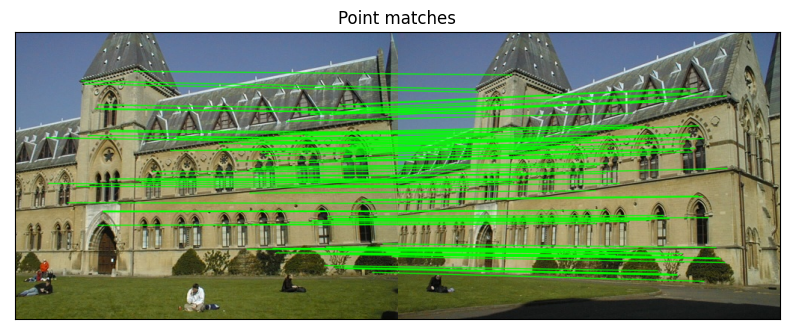

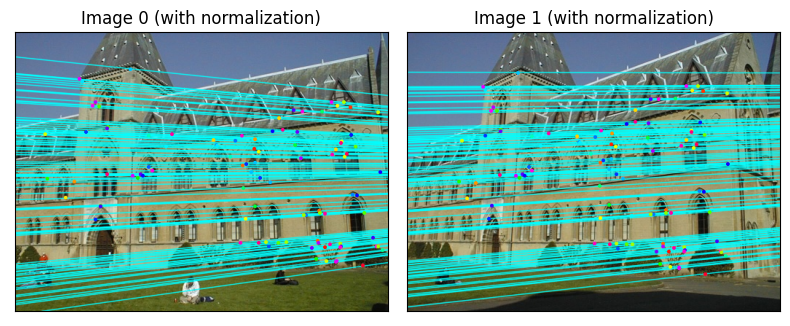

In [21]:
img0, img1, x0, x1, _, _ = load_data('library')

n_matches = 100
x0 = x0[:,:n_matches]
x1 = x1[:,:n_matches]

F, e0, e1 = get_fundamental_matrix_with_normalization(x0, x1)
residual_error = get_residual_error(F, x0, x1)
print(f'The estimated fundamental matrix F is \n{F}')

plot_multiple([draw_point_matches(img0, img1, x0, x1)], 
              ['Point matches'], imwidth=8)
img0_result = draw_points_and_epipolar_lines(img0, x0, F @ x1)
img1_result = draw_points_and_epipolar_lines(img1, x1, F.T @ x0)
plot_multiple([img0_result, img1_result], 
              ['Image 0 (with normalization)', 'Image 1 (with normalization)'])

print(f'Epipole 0: {e0}, epipole 1: {e1}')
print(f'Fitting error: {residual_error:.1f} px')

### Implementing RANSAC
The correspondence set will contain noise and outliers in practice, therefore RANSAC is applied to get a robust estimate.
First, a function id defined which takes an estimated fundamental matrix and the full set of correspondence candidates as input and returns: (1) the ratio, and (2) the indices of the inliers. A point pair $x, x′$ is defined to be an inlier if the distance of $x$ to the epipolar line $\mathrm{l = F^⊤x′}$, as well as the opposite distance, are both less than some threshold $ε$.

In [23]:
def get_inliers(F, x0, x1, eps):
    d0, d1 = get_residual_distance(F, x0, x1)
    indices = np.argwhere(
            np.logical_and(d0 < eps, d1 < eps))[...,0]
    return indices

In [24]:
def get_fundamental_matrix_with_ransac(x0, x1, eps=10, n_iter=1000):
    """
    Args:
        x0, x1: 3xN arrays of N homogenoous points in 2D
        eps: Inlier threshold
        n_iter: Number of iterations
    
    Return:
        F: The 3x3 fundamental martix such taht x2'*F*x1 = 0
        e0: The epipole in image 1 such that F'*e0 = 0
        e1: The epipole in image 2 such that F*e1 = 0 
        inlier_ratio: Ratio of inlier
        inlier_indices: Indices of inlier
    """
    n_pts = x1.shape[1]
    n_sample = 8
    
    indices = np.arange(n_pts)
    best_inlier_indices = []

    for i in range(n_iter):
        # Randomly select seed group of points
        sample_indices = np.random.choice(indices, size=n_sample, replace=False)
        x0_sample = x0[:, sample_indices]
        x1_sample = x1[:, sample_indices]

        # Compute transformation
        F, e0, e1 = get_fundamental_matrix_with_normalization(x0_sample, x1_sample)

        # Find inliers
        inlier_indices = get_inliers(F, x0, x1, eps)        
        if len(inlier_indices) > len(best_inlier_indices):
            best_inlier_indices = inlier_indices
            
    if len(best_inlier_indices) < 8:
        raise RuntimeError('Too few inliers found.')
            
    # Estimate fundamental matrix again with all inliers
    F, e0, e1 = get_fundamental_matrix_with_normalization(
            x0[:, best_inlier_indices], x1[:, best_inlier_indices])
    
    return F, e0, e1, best_inlier_indices

Outlier pairs are created artificially using `inject_outliers` function to simulate teh effect of noisy point correspondence estimation. (Since we are working with precomputed ground-truth point correspondences loaded from a file)

In [25]:
def inject_outliers(img, x0, x1, outlier_ratio):
    """Artifically create outliers.
    
    Args:
        img: Image, used only for size
        x0, x1: Input 3xN points 
        outlier_ratio: Probability (ratio) of outlier
        
    Returns:
        x0_noisy, x1_noisy: Output points (with outlier)
        inlier_mask: 1D binary array
    """
    n_pts = x0.shape[1]
    h, w = img.shape[:2]
    
    outlier_mask = np.random.uniform(size=n_pts) < outlier_ratio
    n_outliers = sum(outlier_mask)
    outlier_x01 = np.random.randint(low=0, high=w, size=(2, n_outliers))
    outlier_y01 = np.random.randint(low=0, high=h, size=(2, n_outliers))
    
    x0_noisy, x1_noisy = x0.copy(), x1.copy()
    x0_noisy[0, outlier_mask] = np.random.randint(low=0, high=w, size=n_outliers)
    x0_noisy[1, outlier_mask] = np.random.randint(low=0, high=h, size=n_outliers)
    x1_noisy[0, outlier_mask] = np.random.randint(low=0, high=w, size=n_outliers)
    x1_noisy[1, outlier_mask] = np.random.randint(low=0, high=h, size=n_outliers)

    return x0_noisy, x1_noisy, np.invert(outlier_mask)

-------- Without RANSAC --------
The estimated fundamental matrix F is 
[[ 3.60308232e-06 -9.16496042e-06  3.50400617e-03]
 [ 1.14815326e-05 -1.51347539e-05  5.79783376e-03]
 [-6.84921586e-03 -1.38533109e-04  3.87143895e-02]]
Epipole 0: [-2.07613445e+03  1.24806502e+03  1.00000000e+00], epipole 1: [ -2.06418552 381.51487633   1.        ]
Fitting error: 22.5 px
-------- With RANSAC --------
The estimated fundamental matrix F is 
[[ 8.13226556e-07  6.67560718e-06 -6.63431592e-04]
 [-1.35701126e-05 -9.03379147e-07 -3.88716418e-03]
 [ 1.67570702e-03  5.31879149e-03 -2.24922219e-01]]
Epipole 0: [-786.41719395   76.35689619    1.        ], epipole 1: [-295.46247294  135.37488005    1.        ]
Fitting error: 0.2 px
Inlier ratio: 80% (groundtruth: 78%)


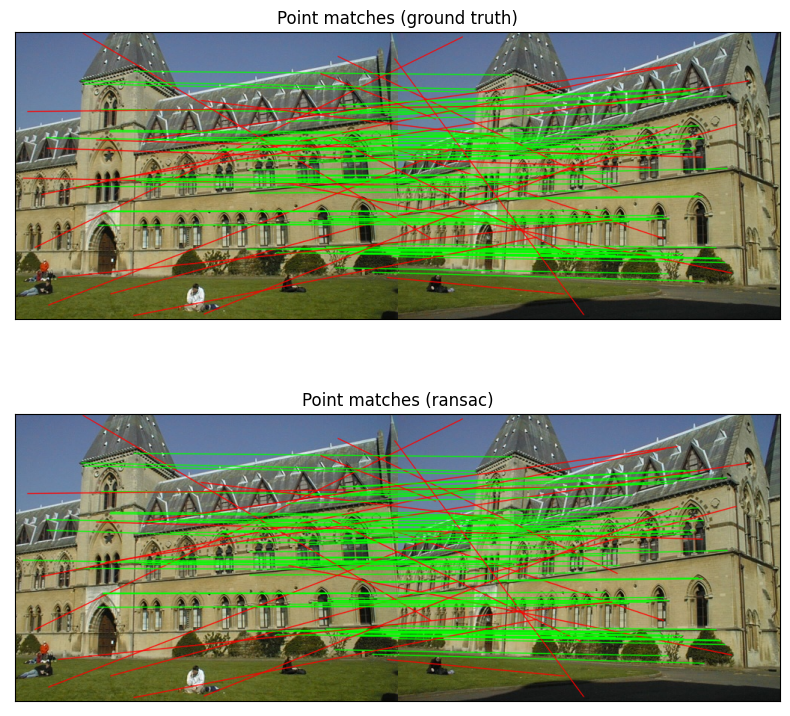

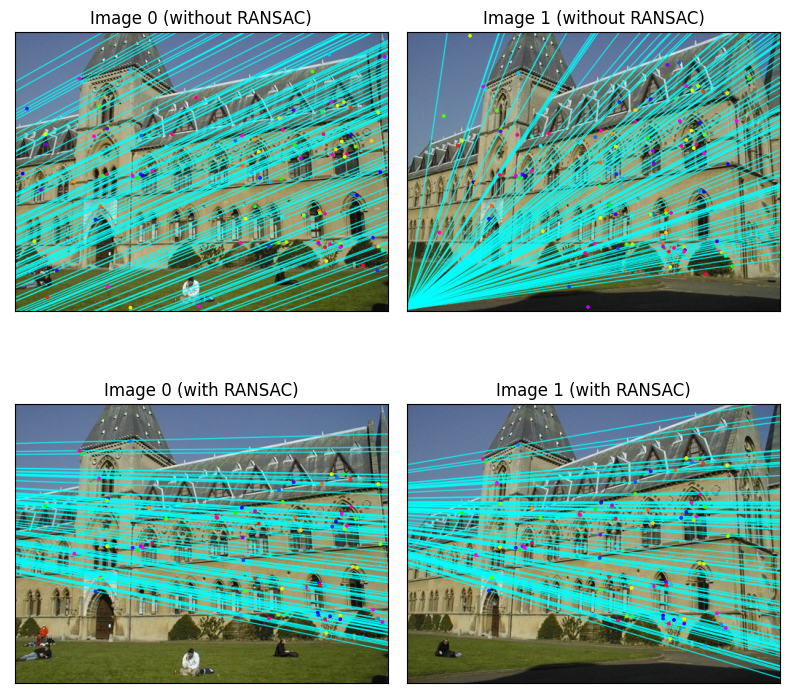

In [27]:
img0, img1, x0, x1, _, _ = load_data('library')
n_matches = 100
x0 = x0[:, :n_matches]
x1 = x1[:, :n_matches]
x0, x1, inlier_mask = inject_outliers(img0, x0, x1, outlier_ratio=0.3)
x0_inlier, x1_inlier = x0[:, inlier_mask], x1[:, inlier_mask]
inlier_ratio = sum(inlier_mask) / x0.shape[1]

# Without RANSAC
F_vanilla, e0_vanilla, e1_vanilla = get_fundamental_matrix_with_normalization(x0, x1)
residual_error_vanilla = get_residual_error(F_vanilla, x0_inlier, x1_inlier)
print('-------- Without RANSAC --------')
print(f'The estimated fundamental matrix F is \n{F_vanilla}')
print(f'Epipole 0: {e0_vanilla}, epipole 1: {e1_vanilla}')
print(f'Fitting error: {residual_error_vanilla:.1f} px')

# With RANSAC
eps = 1
n_iter = 1000
F_ransac, e0_ransac, e1_ransac, inlier_indices = get_fundamental_matrix_with_ransac(
    x0, x1, eps, n_iter)
residual_error_ransac = get_residual_error(F_ransac, x0_inlier, x1_inlier)
inlier_ratio_ransac = len(inlier_indices) / x0.shape[1]
inlier_mask_ransac = np.zeros(x0.shape[1], dtype=bool)
inlier_mask_ransac[inlier_indices] = True
print('-------- With RANSAC --------')
print(f'The estimated fundamental matrix F is \n{F_ransac}')
print(f'Epipole 0: {e0_ransac}, epipole 1: {e1_ransac}')
print(f'Fitting error: {residual_error_ransac:.1f} px')
print(f'Inlier ratio: {inlier_ratio_ransac:.0%} (groundtruth: {inlier_ratio:.0%})')

# Plotting
plot_multiple([draw_point_matches(img0, img1, x0, x1, inlier_mask),
              draw_point_matches(img0, img1, x0, x1, inlier_mask_ransac)], 
              ['Point matches (ground truth)',
              'Point matches (ransac)'], imwidth=8, max_columns=1)

img0_vanilla = draw_points_and_epipolar_lines(img0, x0, F_vanilla @ x1)
img1_vanilla = draw_points_and_epipolar_lines(img1, x1, F_vanilla.T @ x0)
img0_ransac = draw_points_and_epipolar_lines(img0, x0_inlier, F_ransac @ x1_inlier)
img1_ransac = draw_points_and_epipolar_lines(img1, x1_inlier, F_ransac.T @ x0_inlier)
plot_multiple([img0_vanilla, img1_vanilla, img0_ransac, img1_ransac], 
              ['Image 0 (without RANSAC)', 'Image 1 (without RANSAC)',
               'Image 0 (with RANSAC)', 'Image 1 (with RANSAC)'], max_columns=2)

## Triangulation

In [28]:
# Firstly, a Function to find centers of both the cameras
def camera_center_from_projection_matrix(P):
    
    _, _, Vt = np.linalg.svd(P)
    center = Vt[-1, :-1] / Vt[-1,-1]
    return center

In [29]:
img0, img1, x0, x1, P0, P1 = load_data('library')
C0 = camera_center_from_projection_matrix(P0)
C1 = camera_center_from_projection_matrix(P1)

print(f'P0: {P0}')
print(f'P1: {P1}')
print(f'C0: {C0}')
print(f'C1: {C1}')

P0: [[-4.5250208e+01  4.8215478e+02  4.0948922e+02  3.4440464e+03]
 [ 4.8858466e+02  2.7346374e+02 -1.3977268e+02  4.8030231e+03]
 [-1.9787463e-01  8.8042214e-01 -4.3093212e-01  2.8032556e+01]]
P1: [[-5.9593834e+01  5.5643970e+02  2.3093716e+02  3.5683545e+03]
 [ 4.6419679e+02  2.2628430e+02 -1.9605278e+02  4.8734171e+03]
 [-1.9116708e-01  7.2057697e-01 -6.6650130e-01  2.8015392e+01]]
C0: [  7.28863053 -21.52118112  17.73503585]
C1: [  6.89405488 -15.39232716  23.41498687]


Defining a function *triangulate* that uses linear least-square method to triangulate the position of a matching point pair in 3D, as described above. A well suited helper function is *vector_to_skew(v)* which returns a skew symmetric matrix from the vector v with 3 elements

In [30]:
def vector_to_skew(vec):
    return np.array([[0,      -vec[2], vec[1]],
                     [ vec[2], 0,     -vec[0]],
                     [-vec[1], vec[0], 0]])

In [31]:
def triangulate(x0, x1, P0, P1):
    """ Triangulate matching points.
    Args:
        x0, x1: 3xN matrices of matching points (homogeneous)
        P0, P1: 3X4 camera matrices

    Returns:
        X: 3xN matrix of points in world space
    """
    X = np.empty((4, x0.shape[1]), dtype=np.float64)
    for i in range(x0.shape[1]):
        A = np.concatenate([
            vector_to_skew(x0[:, i])[:2] @ P0,
            vector_to_skew(x1[:, i])[:2] @ P1], axis=0)
        _, _, Vt = np.linalg.svd(A, full_matrices=False)
        X[:, i] = Vt[-1, :] / Vt[-1, -1]
    return X

A function is defined to compute the reprojection errors (average distance) between the observed 2D points and the projected 3D points in the two images. 

In [32]:
def get_reprojection_error(X, x, P):
    
    x_p = P @ X
    res = x - x_p / x_p[2, :]
    distance = np.hypot(res[0, :], res[1, :])
    
    return np.mean(distance)

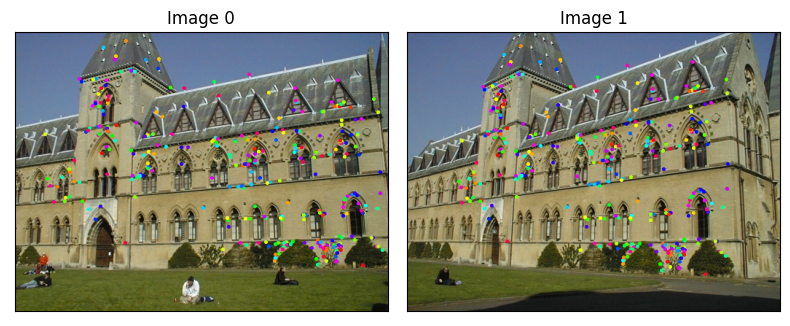

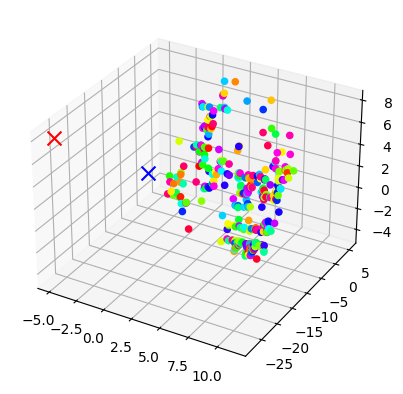

Reprojection error: 0.1 px


In [33]:
def plot_3d_reconstruction(X, C0, C1):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    c = colors[:X.shape[1]]/255
    ax.scatter(X[0], X[1], X[2], c=c, alpha=1)
    ax.scatter(C0[0], C0[1], C0[2], color='red', s=100, marker='x')
    ax.scatter(C1[0], C1[1], C1[2], color='blue', s=100, marker='x')
    plt.show()

X = triangulate(x0, x1, P0, P1)
error0 = get_reprojection_error(X, x0, P0)
error1 = get_reprojection_error(X, x1, P1)
error = 0.5 * (error0 + error1)

# Rotate the visualization to be more recognizable.
U,S,Vt = np.linalg.svd(P0[:3,:3], full_matrices=False)
rot = U @ Vt
rot = np.array([[1,0,0], [0,0,1], [0,-1,0]]) @ rot

plot_multiple([draw_keypoints(img0, x0), draw_keypoints(img1, x1)], 
              ['Image 0', 'Image 1'])
plot_3d_reconstruction(rot @ X[:3]/X[3], rot @ C0, rot @ C1)
print(f'Reprojection error: {error:.1f} px')